###  Refernece:https://github.com/unslothai/unsloth

### Installation

In [1]:
import sys
print(sys.executable)

/home/ysm/anaconda3/envs/unsloth_env/bin/python


In [2]:
# !{sys.executable} -m pip install unsloth

### Unsloth

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.53.1.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 2. Max memory: 23.51 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.6.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Alpaca.ipynb)

For text completions like novel writing, try this [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Mistral_(7B)-Text_Completion.ipynb).

In [4]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instruction = "Classify the following medical transcription into the correct medical specialty."
    inputs = examples["transcription"]
    outputs = examples["medical_specialty"]

    texts = [
        alpaca_prompt.format(instruction, input_, output_) + EOS_TOKEN
        for input_, output_ in zip(inputs, outputs)
    ]
    return {"text": texts}

In [8]:
##--------------데이터 전처리------------

In [17]:
from datasets import load_dataset, DatasetDict
import pandas as pd
from sklearn.utils import resample

# 데이터 로드
full_dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial", split="train+validation+test")
full_dataset = full_dataset.map(formatting_prompts_func, batched=True)

Repo card metadata block was not found. Setting CardData to empty.


In [18]:
# 2. 전체 데이터에 대해서 진료과별 개수 확인
full_df = pd.DataFrame(full_dataset)
specialty_counts = full_df['medical_specialty'].value_counts()
print(specialty_counts)

medical_specialty
Cardiovascular / Pulmonary    742
Orthopedic                    408
Neurology                     282
Gastroenterology              222
Obstetrics / Gynecology       182
Hematology - Oncology         120
Neurosurgery                  109
ENT - Otolaryngology           80
Nephrology                     71
Psychiatry / Psychology        68
Ophthalmology                  66
Pediatrics - Neonatal          64
Radiology                      50
Name: count, dtype: int64


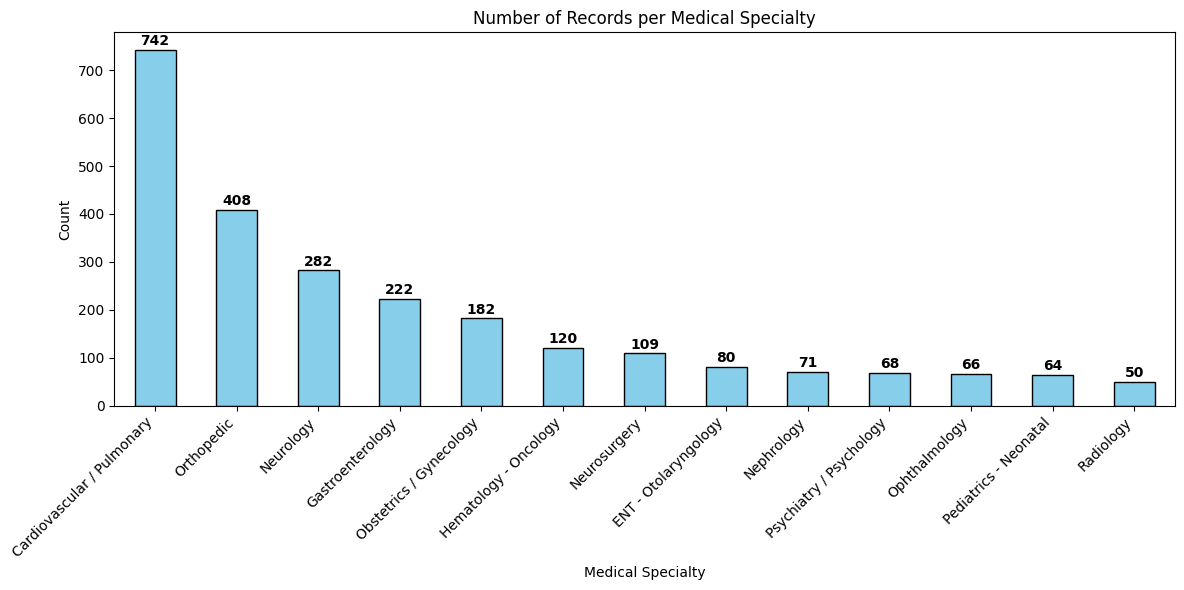

In [19]:
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
specialty_counts.plot(kind='bar', color='skyblue', edgecolor='black')

for i, count in enumerate(specialty_counts):
    plt.text(i, count + 10, str(count), ha='center', color='black', fontweight='bold')

plt.title("Number of Records per Medical Specialty")
plt.xlabel("Medical Specialty")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

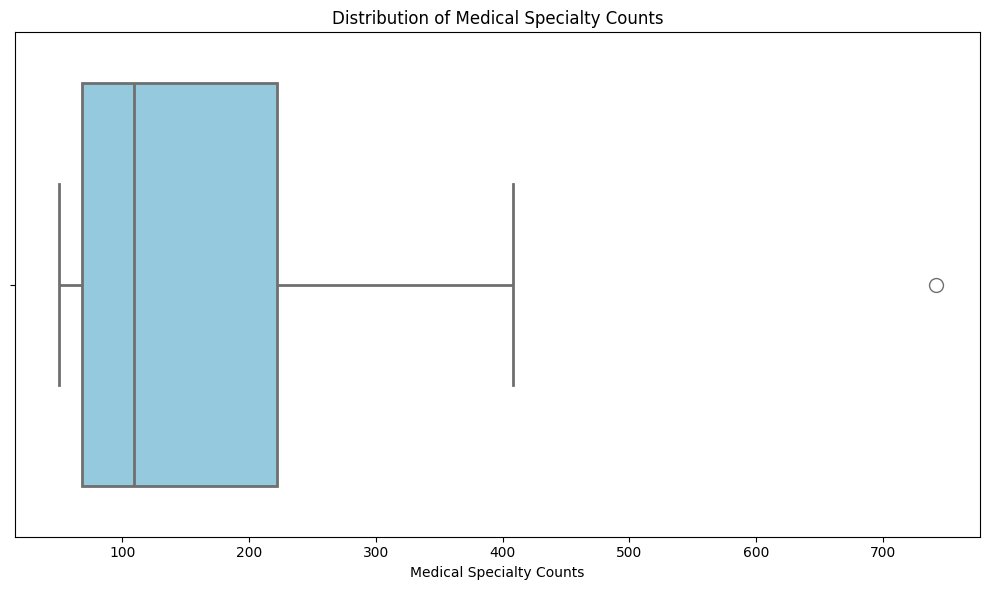

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 박스플롯 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=specialty_counts, color='skyblue', fliersize=10, linewidth=2)

# 제목, 레이블
plt.title("Distribution of Medical Specialty Counts")
plt.xlabel("Medical Specialty Counts")
plt.tight_layout()
plt.show()

In [21]:
# 3. 가장 많은 데이터를 가진 클래스 (Cardiovascular / Pulmonary) 50% 줄이기
majority_class = full_df[full_df['medical_specialty'] == 'Cardiovascular / Pulmonary']

# 샘플 수 50% 줄이기
majority_class_downsampled = resample(majority_class, 
                                      replace=False,    # 중복 없이 샘플링
                                      n_samples=int(len(majority_class) * 0.6),  # 50% 샘플
                                      random_state=42)

# 다른 클래스와 합치기
full_df_downsampled = pd.concat([full_df[full_df['medical_specialty'] != 'Cardiovascular / Pulmonary'], majority_class_downsampled])

In [22]:
# 4. 70개 미만의 데이터를 가진 데이터 삭제
specialty_counts_after_50 = full_df_downsampled['medical_specialty'].value_counts()

# 70개 미만인 클래스 삭제
full_df_cleaned = full_df_downsampled[full_df_downsampled['medical_specialty'].isin(specialty_counts_after_50[specialty_counts_after_50 >= 70].index)]

# 결과 확인
print(full_df_cleaned['medical_specialty'].value_counts())

medical_specialty
Cardiovascular / Pulmonary    445
Orthopedic                    408
Neurology                     282
Gastroenterology              222
Obstetrics / Gynecology       182
Hematology - Oncology         120
Neurosurgery                  109
ENT - Otolaryngology           80
Nephrology                     71
Name: count, dtype: int64


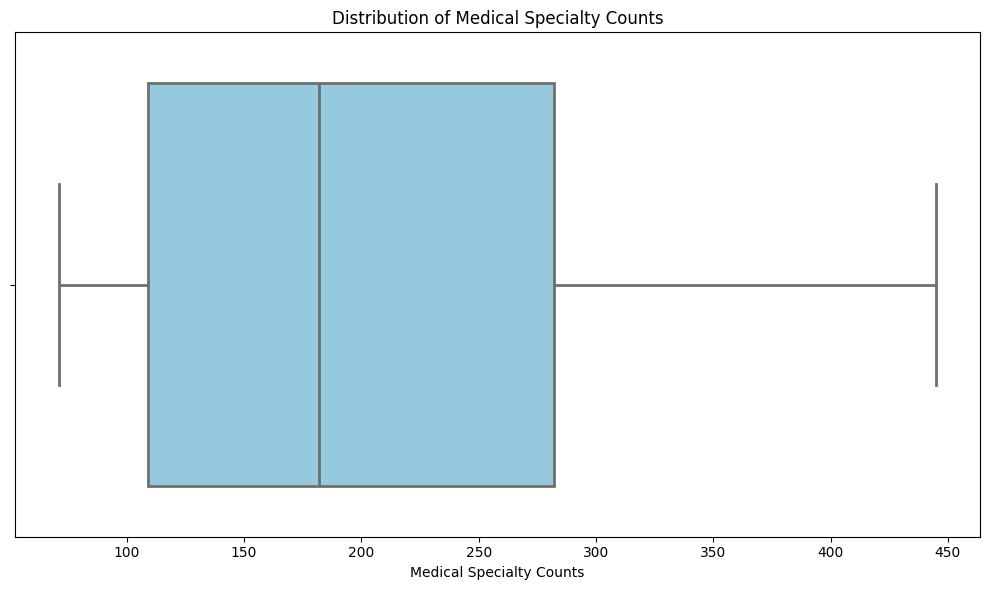

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 진료과목별 개수
specialty_counts = full_df_cleaned['medical_specialty'].value_counts()

# 박스플롯 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=specialty_counts, color='skyblue', fliersize=10, linewidth=2)

# 제목, 레이블
plt.title("Distribution of Medical Specialty Counts")
plt.xlabel("Medical Specialty Counts")
plt.tight_layout()
plt.show()

In [25]:
# 5. train, test split (train:test = 7:3)
from datasets import Dataset, DatasetDict
from sklearn.utils import resample
import pandas as pd

# full_df_cleaned가 pandas DataFrame)datasets.Dataset 객체로 변환
dataset = Dataset.from_pandas(full_df_cleaned)

# SEED 변경하여 5번 분할 반복
seeds = [42, 123, 567, 890, 1001]  # 5개의 SEED 값

# 반복 실행하여 5번 분할 결과 저장
datasets_list = []

for seed in seeds:
    print(f"\nSEED {seed}로 분할 진행:")
    
    # 데이터 분할 (train:test = 7:3)
    train_testvalid = dataset.train_test_split(test_size=0.3, seed=seed)
    test_valid_split = train_testvalid['test'].train_test_split(test_size=0.5, seed=seed)

    # DatasetDict에 저장
    final_dataset = DatasetDict({
        'train': train_testvalid['train'],
        'validation': test_valid_split['train'],
        'test': test_valid_split['test']
    })
    
    datasets_list.append(final_dataset)  # 결과 저장

# 각 SEED별로 데이터셋 확인
for i, dataset in enumerate(datasets_list):
    print(f"\nDataset for SEED {seeds[i]}:")
    print(f"Train size: {len(dataset['train'])}, Validation size: {len(dataset['validation'])}, Test size: {len(dataset['test'])}")


SEED 42로 분할 진행:

SEED 123로 분할 진행:

SEED 567로 분할 진행:

SEED 890로 분할 진행:

SEED 1001로 분할 진행:

Dataset for SEED 42:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 123:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 567:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 890:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 1001:
Train size: 1343, Validation size: 288, Test size: 288


In [28]:
from datasets import load_from_disk

# 첫 번째 SEED의 데이터를 불러오기
first_seed_dataset = datasets_list[0]

# train, validation, test 데이터 접근
train_dataset = first_seed_dataset['train']
eval_dataset = first_seed_dataset['validation']
test_dataset = first_seed_dataset['test']

# 사용 예시: 데이터 개수 확인
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(validation_data)}")
print(f"Test size: {len(test_data)}")

Train size: 1343
Validation size: 288
Test size: 288


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [32]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc,
        
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1343 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/288 [00:00<?, ? examples/s]

In [33]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.51 GB.
7.625 GB of memory reserved.


In [34]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,343 | Num Epochs = 3 | Total steps = 60
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 4 x 1) = 64
 "-____-"     Trainable parameters = 41,943,040 of 8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.050800
2,2.038400
3,2.061000
4,1.974200
5,1.975900
6,1.972600
7,1.866500
8,1.781900
9,1.781600
10,1.729200


In [35]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(usemory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

NameError: name 'usemory_for_lora' is not defined

# Test Evaluation

100%|█████████████████████████████████████████| 288/288 [00:56<00:00,  5.07it/s]

✅ Accuracy: 0.8368055555555556

📄 Classification Report:
                          precision    recall  f1-score   support

cardiovascular/pulmonary       0.92      0.95      0.94        76
      ent/otolaryngology       1.00      1.00      1.00         9
        gastroenterology       0.80      0.96      0.87        25
     hematology/oncology       0.58      0.41      0.48        17
              nephrology       0.85      0.73      0.79        15
               neurology       0.73      0.84      0.78        38
            neurosurgery       1.00      0.50      0.67        16
   obstetrics/gynecology       0.93      0.86      0.89        29
              orthopedic       0.83      0.84      0.83        63

               micro avg       0.85      0.84      0.84       288
               macro avg       0.85      0.79      0.81       288
            weighted avg       0.85      0.84      0.84       288



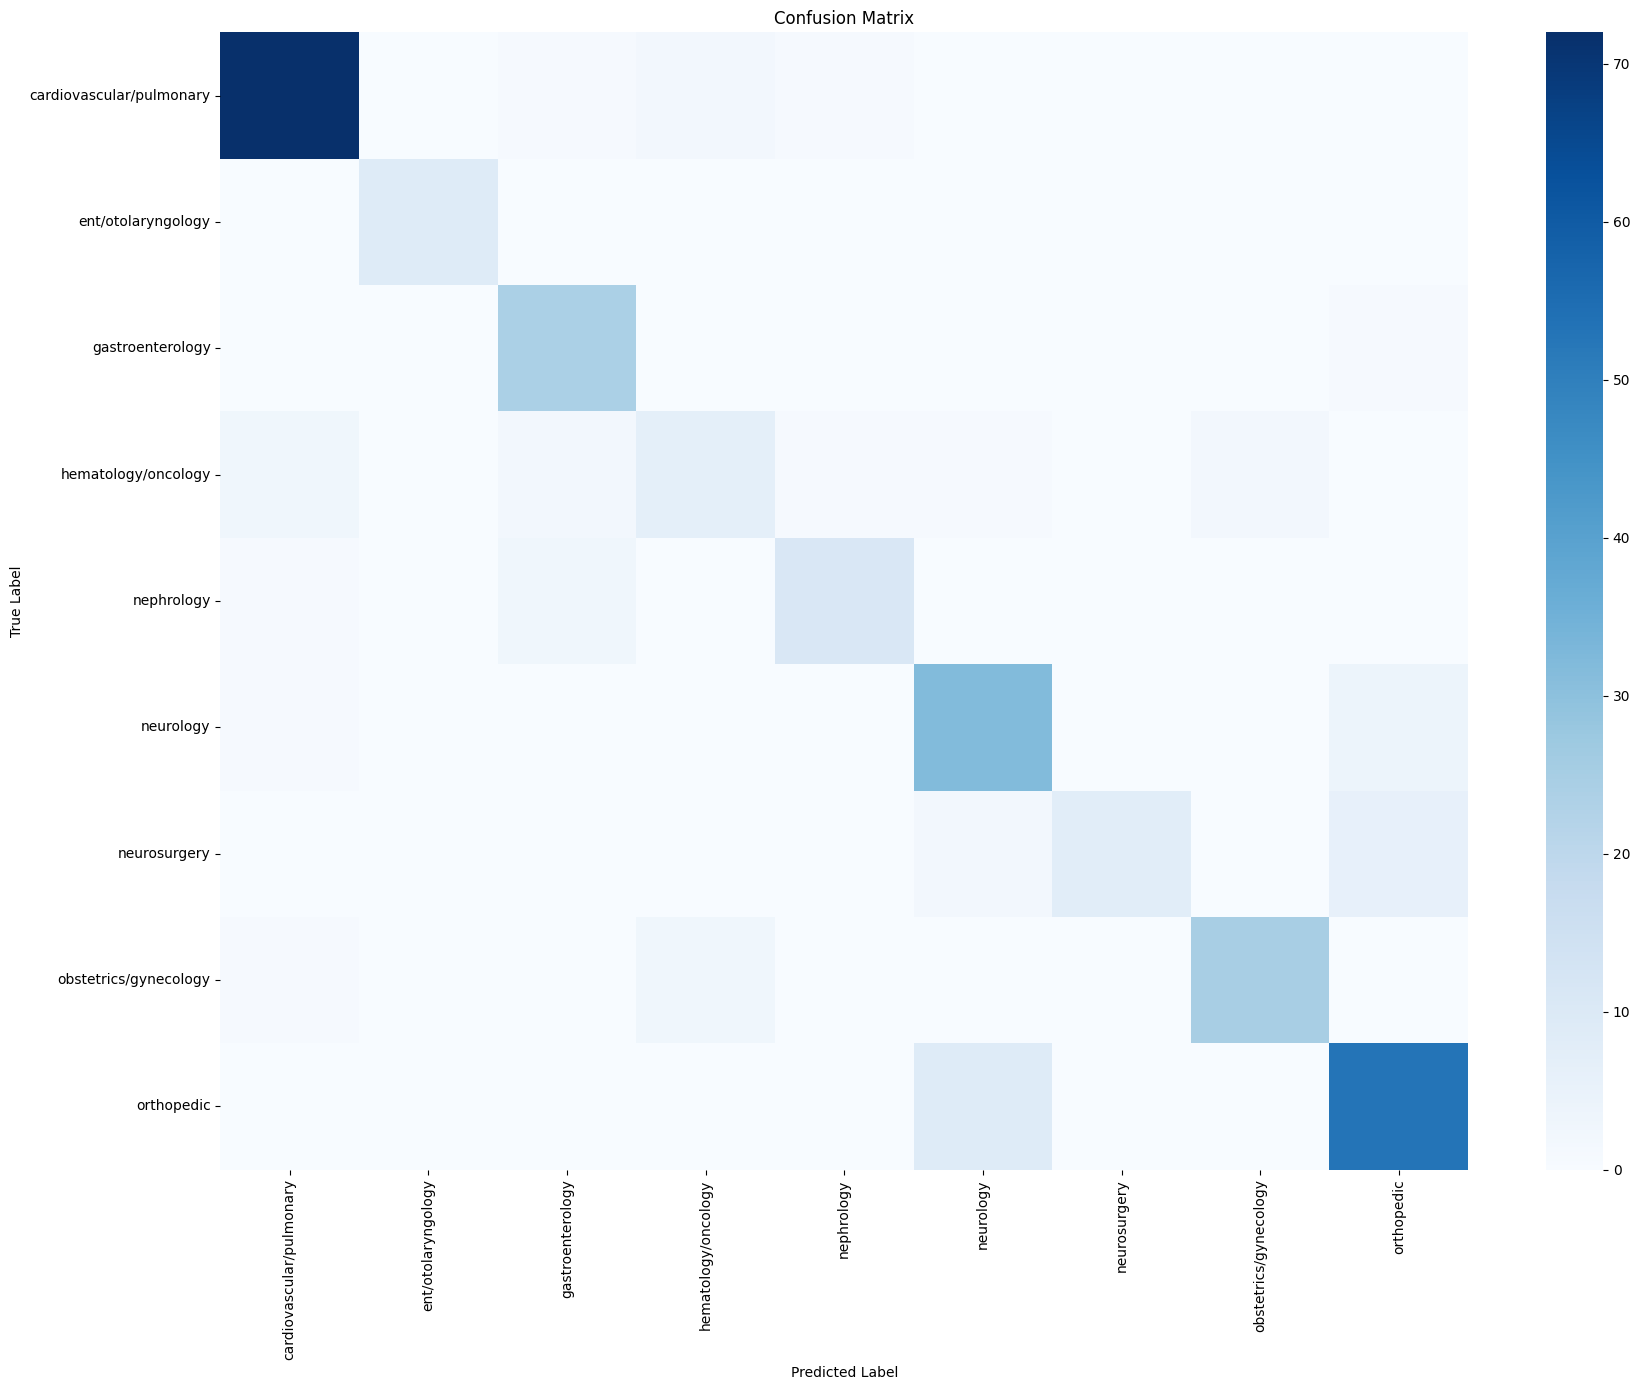


--- examples ---

Example 1:
Transcription:
PREOPERATIVE DIAGNOSIS:,  Bunion, right foot.,POSTOPERATIVE DIAGNOSIS:,  Bunion, right foot.,PROCEDURE PERFORMED:,  Austin/akin bunionectomy, right foot.,HISTORY: , This 77-year-old African-American female presents to ABCD General Hospital with the above chief complaint.  The patient states she has had a bunion deformity for as long as she can remember that has progressively become worse and more painful.  The patient has attempted conservative treatment without long-term relief of symptoms and desires surgical treatment.,PROCEDURE DETAILS:,  An IV was instituted by Department of Anesthesia in the preop holding area.  The patient was transported to the operating room and placed on the operating table in the supine position with a safety strap across her lap.  Copious amounts of Webril were placed around the right ankle followed by blood pressure cuff.  After adequate sedation by the Department of Anesthesia, a total of 15 cc of 1:1 mixture o

In [36]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

# example
examples_to_show = 3  
example_results = []

# Alpaca prompt 템플릿
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction = "Classify the following medical transcription into the correct medical specialty."

# 라벨 전처리 함수
def normalize_label(label):
    return label.lower().replace("-", "/").replace(" / ", "/").strip()

# 입력 길이 제한용 토큰 수
MAX_INPUT_TOKENS = 4096

labels, preds = [], []

# 라벨 집합 확보 (정규화된 기준으로)
all_classes = sorted(list({normalize_label(x["medical_specialty"]) for x in test_dataset}))

for example in tqdm(test_dataset):
    transcription = example["transcription"]
    true_label = normalize_label(example["medical_specialty"])
    labels.append(true_label)

    prompt = alpaca_prompt.format(instruction, transcription, "")

    # 토크나이징 + 길이 제한
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=32, use_cache=True)
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # "### Response:" 이후 예측값만 추출
    response = output_text.split("### Response:")[-1].strip().split("\n")[0]
    pred = normalize_label(response)
    preds.append(pred)

    # 평가 결과 예시 저장
    if len(example_results) < examples_to_show:
        example_results.append({
            "transcription": transcription,
            "true_label": true_label,
            "predicted_label": pred,
            "model_response": response,
        })

# 정확도 및 리포트 출력
print("✅ Accuracy:", accuracy_score(labels, preds))
print("\n📄 Classification Report:")
print(classification_report(labels, preds, labels=all_classes))

# Confusion matrix
cm = confusion_matrix(labels, preds, labels=all_classes)

plt.figure(figsize=(18, 14))
sns.heatmap(cm, xticklabels=all_classes, yticklabels=all_classes, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 예시 결과 3개 출력
print("\n--- examples ---")
for i, r in enumerate(example_results, 1):
    print(f"\nExample {i}:")
    print(f"Transcription:\n{r['transcription']}")
    print(f"True Label: {r['true_label']}")
    print(f"Predicted Label: {r['predicted_label']}")
    print(f"Model Response: {r['model_response']}")

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [37]:
model.save_pretrained("lora_model_7_3_seed1")  # Local saving
tokenizer.save_pretrained("lora_model_7_3_seed1")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model_7_3_seed1/tokenizer_config.json',
 'lora_model_7_3_seed1/special_tokens_map.json',
 'lora_model_7_3_seed1/chat_template.jinja',
 'lora_model_7_3_seed1/tokenizer.json')

# zero-shot